In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.data import (
    chunk_and_tokenize, compute_nats_to_bpb_ratio, silence_datasets_messages
)
import torch as th

def load_stuff(name, device = 'cuda:0'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/val.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    processed = chunk_and_tokenize(dataset, tokenizer)
    ratio = compute_nats_to_bpb_ratio(dataset, processed)
    return model, tokenizer, processed, ratio

In [ ]:
pythia, pythia_tokenizer, pythia_data, nat_to_bpb = load_stuff("EleutherAI/pythia-125m")

In [21]:
import torch as th

hists = th.load('/mnt/ssd-1/nora/real-lenses/pythia/125m/next/eval_histograms.pt')

([<matplotlib.axis.YTick at 0x7f326affc250>,
 [Text(0, 0.0, '0%'),
  Text(0, 0.1, '10%'),
  Text(0, 0.2, '20%'),
  Text(0, 0.30000000000000004, '30%'),
  Text(0, 0.4, '40%'),
  Text(0, 0.5, '50%'),
  Text(0, 0.6000000000000001, '60%'),
  Text(0, 0.7000000000000001, '70%'),
  Text(0, 0.8, '80%'),
  Text(0, 0.9, '90%'),
  Text(0, 1.0, '100%')])

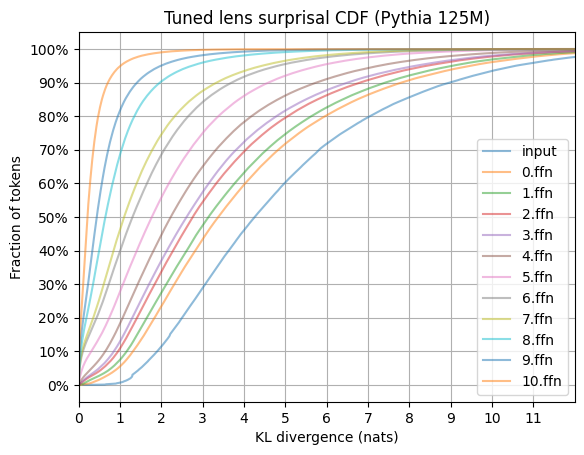

In [51]:
import matplotlib.pyplot as plt
import numpy as np

num_points = 1000
y = np.linspace(0, 1, num_points)

plt.grid()
plt.plot(
    np.quantile(hists['kl']['input'], y),
    y, alpha=0.5, label='input'
)
for i in range(11):
    plt.plot(
        np.quantile(hists['kl'][f'{i}.ffn'], y),
        y, alpha=0.5, label=f'{i}.ffn'
    )

plt.legend()
plt.title("Tuned lens surprisal CDF (Pythia 125M)")
plt.xlabel("KL divergence (nats)")
plt.xlim(0, 12)
plt.xticks(np.arange(0, 12, 1))
plt.ylabel("Fraction of tokens")
plt.yticks(
    ticks=np.linspace(0, 1, 11),
    labels=[f"{i * 10}%" for i in range(11)]
)

Text(0, 0.5, 'Frequency')

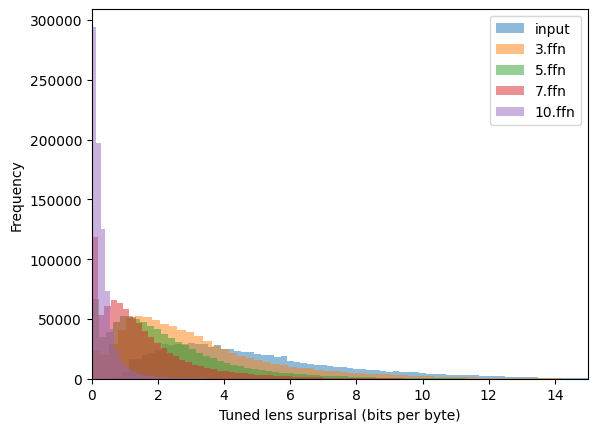

In [29]:
import matplotlib.pyplot as plt

plt.hist(hists['kl']['input'], alpha=0.5, bins=100, label='input')
plt.hist(hists['kl']['3.ffn'], alpha=0.5, bins=100, label='3.ffn')
plt.hist(hists['kl']['5.ffn'], alpha=0.5, bins=100, label='5.ffn')
plt.hist(hists['kl']['7.ffn'], alpha=0.5, bins=100, label='7.ffn')
plt.hist(hists['kl']['10.ffn'], alpha=0.5, bins=100, label='10.ffn')
plt.legend()
plt.xlabel('Tuned lens surprisal (bits per byte)')
plt.xlim(0, 15)
plt.ylabel('Frequency')

In [41]:
from typing import cast, Callable, Union
import functorch as fth


def spherical_metric(x: th.Tensor) -> th.Tensor:
    theta, phi = x.unbind(dim=-1)
    diag = th.stack([
        th.ones_like(phi),
        th.sin(theta) ** 2,
    ], dim=-1)
    return diag.diag_embed()


def geodesic_system(
        metric: Callable[[th.Tensor], th.Tensor]
    ) -> Callable[[th.Tensor, th.Tensor], th.Tensor]:
    # The second derivative is usually written as:
    #   x''(t) = -0.5 * M^{-1} @ dM_dx.T @ kron(x'(t), x'(t))
    # where dM_dx is the Jacobian of the flattened metric.
    #
    # With basic matrix identities can rewrite this as:
    #   x''(t) = -0.5 * solve(M, @ [kron(x'(t), x'(t)).T @ dM_dx].T)
    # replacing the transposed Jacobian-vector product with a
    # vector-Jacobian product. We can then use functorch.vjp to
    # compute the VJP without materializing the full Jacobian.

    def system(t: th.Tensor, y: th.Tensor) -> th.Tensor:
        x, v = y.chunk(2, dim=-1)
        *rest, d = x.shape

        # Avoid materializing the full Jacobian
        M_flat, metric_vjp_fn = fth.vjp(lambda x: metric(x).view(-1), x) # type: ignore
        vjp, = metric_vjp_fn(th.kron(v, v).T)

        acc = -0.5 * th.linalg.solve(M_flat.view(*rest, d, d), vjp.T)
        return th.cat([v, acc])
    
    return system

geodesic_system(lambda x: th.eye(2))(th.tensor(0.0), th.cat([th.zeros(2), th.ones(2)]))

v.shape=torch.Size([2]) th.kron(v, v).T.shape=torch.Size([4]) M_flat.shape=torch.Size([4])


tensor([1., 1., -0., -0.])

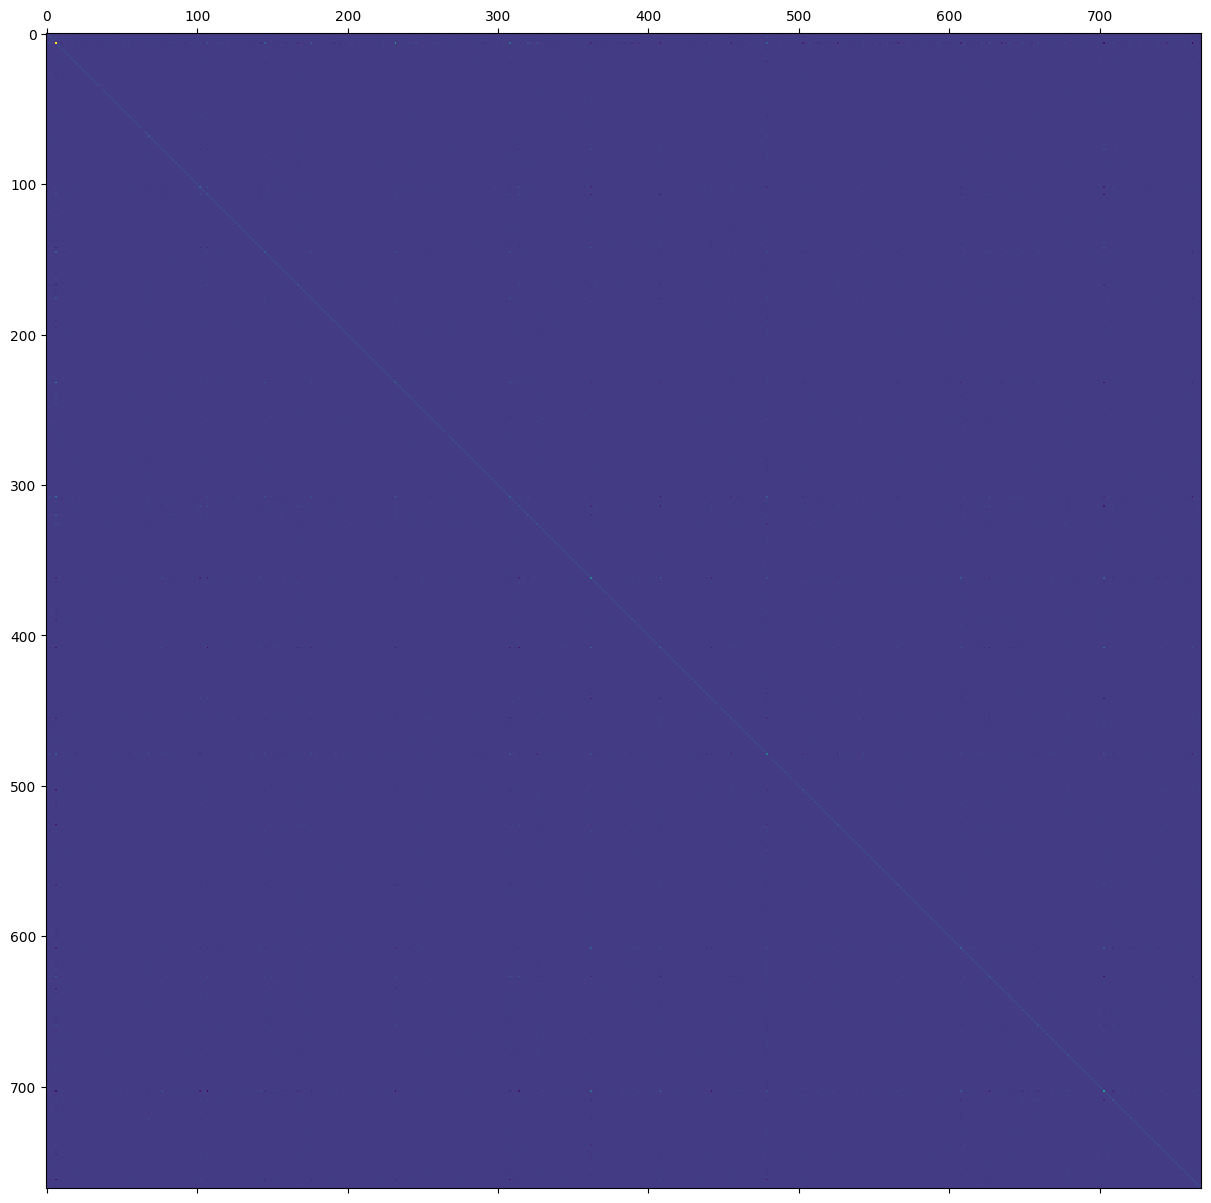

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))

M = decoder.metric_tensor(th.zeros(768, device='cuda:0'))
ax.matshow(M.cpu().numpy())
# fig.colorbar()

In [113]:
from torchdiffeq import odeint

traj = odeint(
    geodesic_system(spherical_metric),
    th.cat([th.randn(2) * 0.5, th.ones(2)]),
    th.linspace(0, 20, 100)
)
traj_x, traj_v = traj.chunk(2, dim=-1)

In [111]:
import matplotlib.pyplot as plt

def spherical_to_cartesian(theta, phi):
    return th.stack([
        th.sin(theta) * th.cos(phi),
        th.sin(theta) * th.sin(phi),
        th.cos(theta),
    ], dim=-1)

cartesian_x, cartesian_y, cartesian_z = spherical_to_cartesian(*traj_x.T).T

In [112]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame({
    "x": cartesian_x,
    "y": cartesian_y,
    "z": cartesian_z,
})
px.line_3d(df, x="x", y="y", z="z")

In [2]:
from tuned_lens.nn import Decoder, TunedLens

pythia_decoder = Decoder(pythia)
next_lens = TunedLens.load("/mnt/ssd-1/nora/real-lenses/pythia/small/").cuda()
cur_lens = TunedLens.load("/mnt/ssd-1/nora/real-lenses/pythia/small/current-token/").cuda()

In [4]:
from tuned_lens.stats import ResidualStats

first_stats = th.load("/mnt/ssd-1/nora/real-lenses/pythia/125m/next/first_token_stats.pt")
pythia_stats = th.load("/mnt/ssd-1/nora/real-lenses/pythia/125m/next/stream_stats.pt")

In [9]:
gpt2_stats = th.load("/mnt/ssd-1/nora/real-lenses/gpt2/small/stream_stats.pt")

In [38]:
import math

class PositionBucketedStats:
    pass


def split_geometric(x: th.Tensor, dim: int) -> list[th.Tensor]:
    N = x.shape[dim]

    steps = round(math.log2(N))
    splits = [2 ** i for i in range(steps)]
    splits[-1] += N - sum(splits)

    return x.split(splits, dim=dim)


In [40]:
foo = th.randn(1000, 768)
[x.shape for x in split_geometric(foo, 0)]

[torch.Size([1, 768]),
 torch.Size([2, 768]),
 torch.Size([4, 768]),
 torch.Size([8, 768]),
 torch.Size([16, 768]),
 torch.Size([32, 768]),
 torch.Size([64, 768]),
 torch.Size([128, 768]),
 torch.Size([256, 768]),
 torch.Size([489, 768])]

In [4]:
from tuned_lens import record_residual_stream

with record_residual_stream(pythia) as stream, th.no_grad():
    x = pythia_data[0]['input_ids'].cuda()
    output = pythia(x, output_hidden_states=True)
    logits = output.logits

In [5]:
from torch.distributions import MultivariateNormal

rest_dists = pythia_stats.mean().zip_map(
    lambda m, c: MultivariateNormal(m, c),
    pythia_stats.covariance()
)

Text(0.5, 1.0, 'Effective dimensionality in GPT-2 small')

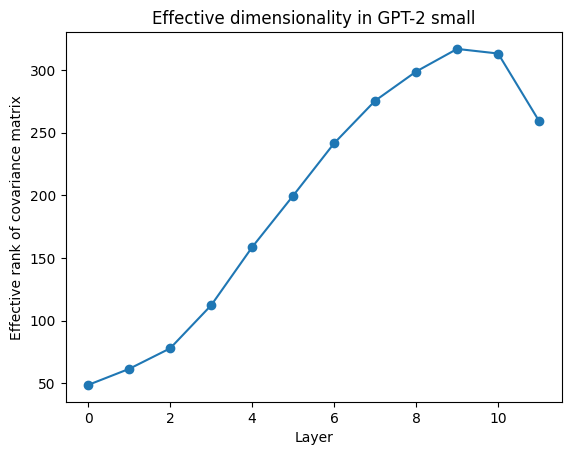

In [7]:
from tuned_lens.stats import effective_rank
import matplotlib.pyplot as plt

gpt2_stats.covariance().map(lambda x: effective_rank(x).cpu()).plot(marker='o')
plt.ylabel("Effective rank of covariance matrix")
plt.title("Effective dimensionality in GPT-2 small")

Text(0.5, 1.0, 'Effective dimensionality in Pythia 125M')

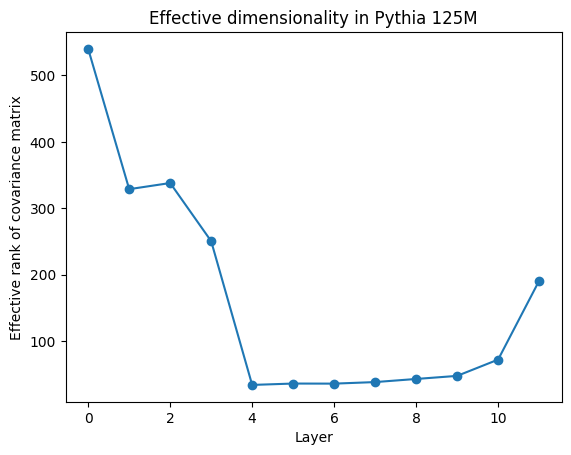

In [5]:
from tuned_lens.stats import effective_rank
import matplotlib.pyplot as plt

pythia_stats.covariance().map(lambda x: effective_rank(x).cpu()).plot(marker='o')
plt.ylabel("Effective rank of covariance matrix")
plt.title("Effective dimensionality in Pythia 125M")

In [7]:
def top_p_mask(logits: th.Tensor, top_p: float = 0.9) -> th.Tensor:
    sorted_logits, indices = logits.sort()
    cum_probs = sorted_logits.softmax(dim=-1).cumsum(-1)
    sorted_mask = cum_probs <= 1 - top_p
    sorted_mask[..., -1] = False  # Always keep the highest token

    # Scatter sorted tensors to original indexing
    return ~sorted_mask.scatter(-1, indices, sorted_mask)


def top_p_truncate(logits: th.Tensor, top_p: float = 0.9) -> th.Tensor:
    mask = top_p_mask(logits, top_p)
    logits = logits.masked_fill(mask, float("-inf"))
    return logits

In [3]:
from torch.distributions import MultivariateNormal
from tqdm.auto import tqdm
from tuned_lens import layer_intervention
from tuned_lens.utils import pytree_map

L = pythia.config.num_hidden_layers
B = 10
S = 20

with th.autocast("cuda"), th.no_grad():
    # First do a clean forward pass on all the data. We save the
    # logits, as well as the keys and values to speed up inference
    # when we do interventions. 
    inputs = pythia_data[:B]['input_ids'].cuda()
    outputs = pythia(
        inputs, labels=inputs, output_hidden_states=True, use_cache=True
    )

    clean_kv = outputs.past_key_values
    clean_loss = th.nn.functional.cross_entropy(
        outputs.logits[..., :-1, :].flatten(0, -2),
        inputs[..., 1:].flatten(),
        reduction="none"
    ).reshape(B, -1).mean(0)
    causal_effects = th.zeros(S, L - 1, device='cuda')

    pbar = tqdm(range(1, S))
    for token_idx in pbar:
        kv_truncated = pytree_map(lambda x: x[..., :token_idx, :], clean_kv)

        for i in range(L - 1):
            lens = next_lens[i + 1]

            def fisher_noise(h):
                h = h.squeeze()
                g = pythia_decoder.metric_tensor(h)

                # Do the matrix inversion with an epsilon to dampen the variance
                # along directions with very small eigenvalues.
                Λ, Q = th.linalg.eigh(g)
                Λ += 1e-3
                Λ_inv = Λ.reciprocal()

                # Keep the trace of the matrix the same
                Λ_inv *= Λ.sum() / Λ_inv.sum()
                g_inv = Q @ Λ_inv.diag_embed() @ Q.mT

                noise_dist = MultivariateNormal(
                    th.zeros_like(h),
                    g_inv.float() * 1000,
                    validate_args=False
                )
                noise = noise_dist.sample()
                z = h + noise
                return z

            with layer_intervention(pythia, [i], fisher_noise):
                outputs = pythia(
                    inputs[:, token_idx, None],
                    past_key_values=kv_truncated
                )
                loss = th.nn.functional.cross_entropy(
                    outputs.logits.squeeze(1),
                    inputs[:, token_idx + 1]
                )

            effect = (loss - clean_loss[token_idx]) / clean_loss[token_idx]
            causal_effects[token_idx, i] = effect
            pbar.set_postfix({"layer": i, "effect": effect.item()})

  0%|          | 0/19 [00:00<?, ?it/s]

In [25]:
foo = pythia(pythia_data[0]['input_ids'].cuda()).logits.detach()

In [48]:
# logits = pythia_decoder(th.randn(1, 768).cuda())
start = 50
N = 100
pinv_init = pythia_decoder.invert(foo[start:N + start], tol=1e-9)
random_init = pythia_decoder.invert(foo[start:N + start], h0=th.randn(N, 768).cuda(), tol=1e-9)

In [46]:
M = pythia_decoder.metric_tensor(pinv_init.preimage)
hess = pinv_init.hessian

th.norm(M - hess) / th.norm(hess)

tensor(0.0427, device='cuda:0')

In [49]:
import torch.nn.functional as F

F.cosine_similarity(pinv_init.preimage, random_init.preimage, dim=1)

tensor([ 0.2706,  0.2603,  0.5150,  0.2184,  0.2902,  0.0682,  0.3783,  0.1476,
        -0.3127, -0.0417,  0.2887,  0.2226,  0.4088, -0.1664,  0.3416,  0.5934,
         0.3874,  0.1795,  0.4586,  0.6648,  0.1614,  0.3872,  0.8128,  0.3300,
         0.4174,  0.2398,  0.2025,  0.2879, -0.1724,  0.1900,  0.5967,  0.4337,
         0.2672,  0.0142,  0.1566,  0.2748,  0.4188,  0.5167,  0.1204,  0.4228,
         0.1226,  0.1536,  0.6745,  0.1062,  0.2221,  0.5540,  0.3806,  0.4269,
         0.4517,  0.7219,  0.6343, -0.0694,  0.2881,  0.1273, -0.1540,  0.1920,
         0.2503, -0.1356, -0.0215,  0.2756,  0.5092,  0.1814,  0.2274,  0.2797,
         0.5797, -0.0060,  0.2834,  0.4973,  0.1645,  0.2954, -0.2136,  0.4385,
         0.2707,  0.2488,  0.3190,  0.1056,  0.3986,  0.5594, -0.0502, -0.0912,
         0.7883,  0.0952,  0.4614,  0.3660,  0.3032,  0.1648,  0.3095, -0.1806,
        -0.0154,  0.2964,  0.4074,  0.1140,  0.4737,  0.2723,  0.2860,  0.4992,
         0.4182,  0.1185,  0.3181,  0.48

In [23]:
pinv_init.preimage.norm(dim=-1).mean()

tensor(27.7126, device='cuda:0')

In [24]:
random_init.preimage.norm(dim=-1).mean()

tensor(27.7128, device='cuda:0')

In [12]:
X = pythia.base_model.wpe.weight.data
gram = X @ X.T

In [24]:
th.fft.fft(X)

tensor([[-4.1879+0.0000j, -1.0296-5.5978j, -2.8452+0.8029j,  ...,
         11.7217+7.7159j, -2.8452-0.8029j, -1.0296+5.5978j],
        [-0.7730+0.0000j, -0.3827-1.6541j,  1.2685-2.3607j,  ...,
          1.7344+2.1192j,  1.2685+2.3607j, -0.3827+1.6541j],
        [-1.7188+0.0000j, -1.2292-1.4958j,  1.8950-1.6854j,  ...,
          1.8207+3.3723j,  1.8950+1.6854j, -1.2292+1.4958j],
        ...,
        [ 2.6115+0.0000j,  0.9276-1.2529j,  4.2621-0.7619j,  ...,
          1.8118-1.0752j,  4.2621+0.7619j,  0.9276+1.2529j],
        [ 2.3241+0.0000j,  0.9500-1.5426j,  3.9982-0.9631j,  ...,
          1.5658-1.1838j,  3.9982+0.9631j,  0.9500+1.5426j],
        [-0.0486+0.0000j, -0.0681-0.0213j, -0.0281-0.0478j,  ...,
         -0.1224+0.0578j, -0.0281+0.0478j, -0.0681+0.0213j]], device='cuda:0')

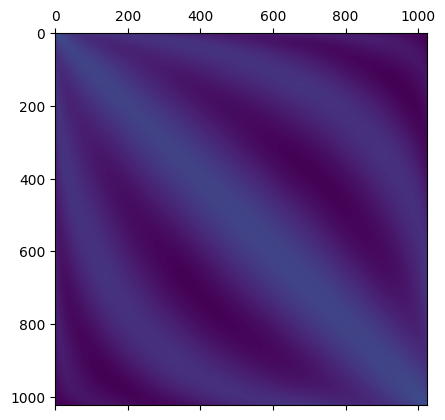

In [14]:
import matplotlib.pyplot as plt

plt.matshow(gram.cpu())